In [ ]:
# https://cseweb.ucsd.edu/classes/wi15/cse255-a/reports/fa15/035.pdf

In [1]:
import gzip
import json
from collections import defaultdict
import scipy
import scipy.optimize
import numpy
import random
import pandas as pd 
from gensim.models import Word2Vec
import nltk
from sklearn.metrics import mean_squared_error
nltk.download('punkt')

unable to import 'smart_open.gcs', disabling that module
[nltk_data] Downloading package punkt to /Users/loriliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from nltk.corpus import wordnet
import pandas as pd
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import gensim
from gensim import corpora
import spacy
# nltk.download()

In [89]:
import statistics
import numpy as np

In [4]:
def parse(filename):
    f = gzip.open(filename, 'r+')
    f.readline()
    for line in f:
#         print(line)
        d = json.loads(line.decode('utf-8'))
        yield d
        

review_data = list(parse('Gift_Cards.json.gz'))
meta_data = list(parse('meta_Gift_Cards.json.gz'))

## Separate Train/test split

In [24]:
random.shuffle(review_data)

In [28]:
len(review_data)

147193

In [33]:
train_review_data = review_data[:100000]
test_review_data = review_data[100000:]

In [53]:
train_review_user = [i['reviewerID'] for i in train_review_data]
train_review_item = [i['asin'] for i in train_review_data]
train_review_text = [i['reviewText'] if 'text' in i else '' for i in train_review_data ]
train_review_rating = [i['overall'] for i in train_review_data]

In [54]:
test_review_user = [i['reviewerID'] for i in test_review_data]
test_review_item = [i['asin'] for i in test_review_data]
test_review_text = [i['reviewText'] if 'text' in i else '' for i in test_review_data]
test_review_rating = [i['overall'] for i in test_review_data]

## Building LDA model from training dataset

In [65]:
user_item_rating_file  = pd.DataFrame({'reviewerID': train_review_user, 'asin':train_review_item,\
                                      'text':train_review_text,'rating':train_review_rating})

In [66]:
user_item_rating_file

,reviewerID,asin,text,rating
0,A1YJDN6MHNXY6B,B00CHQ7I2S,Great gift card box!,5.0
1,A37V633SAQM904,B00G4IV2VI,Great gift for a long distance friend!,5.0
2,A1JHY2F48TSKPH,B00B2TFKHG,Great gift,4.0
3,A2R08XSL4OGRBT,B0062ONJ6U,Easy way to sent a gift when you don't know wh...,5.0
4,A1518NDBG3UR0X,B00K0PO7AO,Very easy gift!,5.0
...,...,...,...,...
99995,A16BFCQXPC0CDP,B005ESMMWW,,5.0
99996,A2WG346KEZ2JF9,B00PG8502O,,5.0
99997,A1EB8BIWBTDGRR,B005EISOUQ,,1.0
99998,A20TT6SN3RVW6,B004LLIL2I,,5.0


In [ ]:
# perform linear regression

In [ ]:
# perform linear regression with LDA
# we perform a
# simple linear regression task with 10 generated topic features
# and basic features which include business stars, user average
# stars, and total votes.

In [57]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [58]:
"""clean the text"""
"""including remove stopwords and punctuation"""
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [60]:
# function to plot most frequent terms
def freq_words(x, terms = 20):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(30,10))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    ax.xaxis.get_label().set_fontsize(15)
    plt.xticks(fontsize=20)
    plt.show()


In [61]:
"""It reduces any given word to its base form 
# thereby reducing multiple forms of a word to a single word."""
def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [69]:
user_item_rating_file["review_clean"] = user_item_rating_file["text"].apply(lambda x: clean_text(x))

In [72]:
user_item_rating_file

,reviewerID,asin,text,rating,review_clean,pos,neg
0,A1YJDN6MHNXY6B,B00CHQ7I2S,Great gift card box!,5.0,great gift card box,0.785,0
1,A37V633SAQM904,B00G4IV2VI,Great gift for a long distance friend!,5.0,great gift long distance friend,0.778,0
2,A1JHY2F48TSKPH,B00B2TFKHG,Great gift,4.0,great gift,1,0
3,A2R08XSL4OGRBT,B0062ONJ6U,Easy way to sent a gift when you don't know wh...,5.0,easy way send gift know buy love ones.\n\nbest...,0.513,0
4,A1518NDBG3UR0X,B00K0PO7AO,Very easy gift!,5.0,easy gift,0.87,0
...,...,...,...,...,...,...,...
99995,A16BFCQXPC0CDP,B005ESMMWW,,5.0,,,
99996,A2WG346KEZ2JF9,B00PG8502O,,5.0,,,
99997,A1EB8BIWBTDGRR,B005EISOUQ,,1.0,,,
99998,A20TT6SN3RVW6,B004LLIL2I,,5.0,,,


In [64]:
user_item_rating_file

,reviewerID,asin,text,rating,review_clean,pos,neg
0,A1YJDN6MHNXY6B,B00CHQ7I2S,Great gift card box!,0.0,0,,
1,A37V633SAQM904,B00G4IV2VI,Great gift for a long distance friend!,0.0,0,,
2,A1JHY2F48TSKPH,B00B2TFKHG,Great gift,0.0,0,,
3,A2R08XSL4OGRBT,B0062ONJ6U,Easy way to sent a gift when you don't know wh...,0.0,0,,
4,A1518NDBG3UR0X,B00K0PO7AO,Very easy gift!,0.0,0,,
...,...,...,...,...,...,...,...
99995,A16BFCQXPC0CDP,B005ESMMWW,,0.0,0,,
99996,A2WG346KEZ2JF9,B00PG8502O,,0.0,0,,
99997,A1EB8BIWBTDGRR,B005EISOUQ,,0.0,0,,
99998,A20TT6SN3RVW6,B004LLIL2I,,0.0,0,,


In [63]:
# display the top 10 negative reviews
negative = user_item_rating_file.sort_values("neg", ascending = False)[["review_clean", "neg"]].head(10)
positive = user_item_rating_file.sort_values("pos", ascending = False)[["review_clean", "neg"]].head(10)


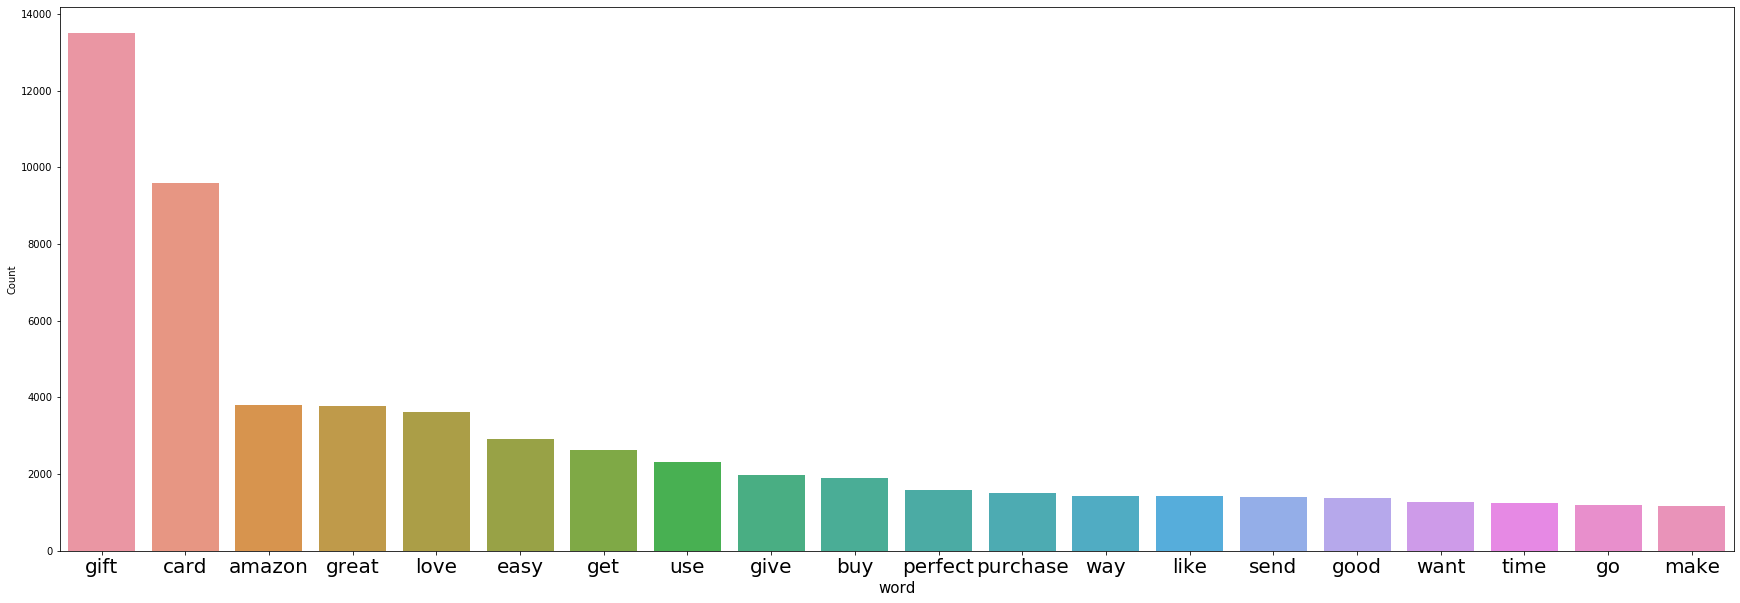

In [73]:
freq_words(user_item_rating_file["review_clean"])

In [74]:
reviews = user_item_rating_file['review_clean']

In [75]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [76]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['great', 'gift', 'long', 'distance', 'friend']


In [77]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['great', 'gift', 'long', 'distance', 'friend']


In [78]:
def LDA_model(reviews=reviews_2):
    dictionary = corpora.Dictionary(reviews)
    doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews]  
    # Creating the object for LDA model using gensim library
    LDA = gensim.models.ldamodel.LdaModel

    # Build LDA model
    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)
    return lda_model, dictionary, doc_term_matrix

In [79]:
lda_model,dictionary, doc_term_matrix = LDA_model()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gensim/models/ldamodel.py:821: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


## WordCloud

In [296]:
from wordCloud import WordCloud

{'perfect': 0.009387867, 'quick': 0.003544054, 'fast': 0.0034962134, 'easy': 0.0033576002, 'delivery': 0.0030075444, 'simple': 0.0018798014, 'shipping': 0.0013073282, 'fun': 0.0011827773, 'thank': 0.0011353181, 'pleased': 0.0010419876}


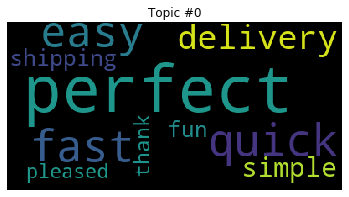

{'work': 0.004985044, 'happy': 0.004280637, 'excellent': 0.002184859, 'service': 0.0011825997, 'mom': 0.0010645408, 'movie': 0.00090242905, 'month': 0.0007612483, 'daughter': 0.000700928, 'plan': 0.00058693666, 'ticket': 0.00055808795}


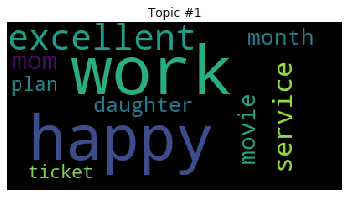

{'great': 0.020586396, 'cute': 0.005345185, 'idea': 0.0036322218, 'tin': 0.0016839925, 'deal': 0.0014164615, 'packaging': 0.0009844165, 'price': 0.00084193936, 'give': 0.0008236992, 'presentation': 0.0007058734, 'country': 0.00062059413}


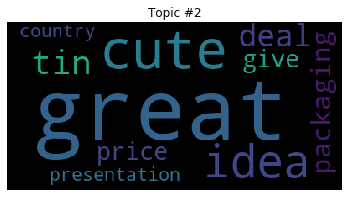

{'time': 0.008596651, 'problem': 0.0027951563, 'number': 0.0011782808, 'code': 0.0011090621, 'first': 0.0010722015, 'fine': 0.0010030374, 'grandson': 0.000716661, 'right': 0.00070182467, 'appreciate': 0.0006417707, 'correct': 0.000579776}


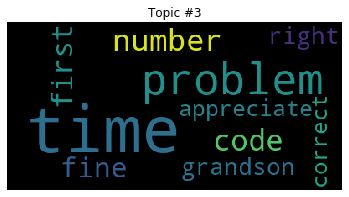

{'gift': 0.04597987, 'card': 0.04541589, 'easy': 0.007547314, 'use': 0.0066289706, 'way': 0.0063095326, 'purchase': 0.0052487613, 'birthday': 0.004656382, 'order': 0.0042841076, 'nice': 0.0038500642, 'recipient': 0.0037358892}


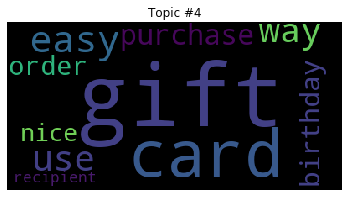

{'good': 0.0116946325, 'product': 0.0033376145, 'food': 0.0013734226, 'restaurant': 0.001072417, 'quality': 0.0009866619, 'adorable': 0.0008751501, 'job': 0.0006788455, 'deal': 0.00057877804, 'graduation': 0.00056924624, 'bear': 0.000482439}


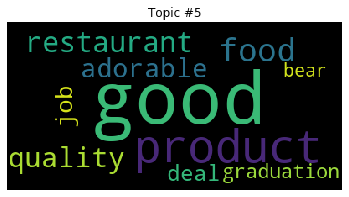

{'love': 0.014854558, 'minute': 0.0049835495, 'convenient': 0.0036054805, 'last': 0.003587459, 'awesome': 0.0017191317, 'home': 0.0010194293, 'color': 0.0009820038, 'size': 0.00068838295, 'husband': 0.00062919996, 'shopping': 0.00061062496}


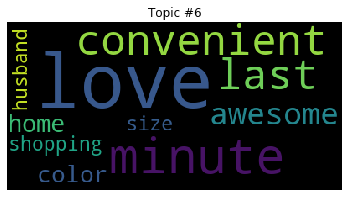

In [311]:
for t in range(lda_model.num_topics):
    plt.figure()
    word_frequence = {x[0]: x[1] for x in lda_model.show_topic(t)}
    print(word_frequence)
    plt.imshow(WordCloud().fit_words(word_frequence))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [80]:
lda_model.print_topics()

[(0,
  '0.009*"perfect" + 0.004*"quick" + 0.003*"fast" + 0.003*"easy" + 0.003*"delivery" + 0.002*"simple" + 0.001*"shipping" + 0.001*"fun" + 0.001*"thank" + 0.001*"pleased"'),
 (1,
  '0.005*"work" + 0.004*"happy" + 0.002*"excellent" + 0.001*"service" + 0.001*"mom" + 0.001*"movie" + 0.001*"month" + 0.001*"daughter" + 0.001*"plan" + 0.001*"ticket"'),
 (2,
  '0.021*"great" + 0.005*"cute" + 0.004*"idea" + 0.002*"tin" + 0.001*"deal" + 0.001*"packaging" + 0.001*"price" + 0.001*"give" + 0.001*"presentation" + 0.001*"country"'),
 (3,
  '0.009*"time" + 0.003*"problem" + 0.001*"number" + 0.001*"code" + 0.001*"first" + 0.001*"fine" + 0.001*"grandson" + 0.001*"right" + 0.001*"appreciate" + 0.001*"correct"'),
 (4,
  '0.046*"gift" + 0.045*"card" + 0.008*"easy" + 0.007*"use" + 0.006*"way" + 0.005*"purchase" + 0.005*"birthday" + 0.004*"order" + 0.004*"nice" + 0.004*"recipient"'),
 (5,
  '0.012*"good" + 0.003*"product" + 0.001*"food" + 0.001*"restaurant" + 0.001*"quality" + 0.001*"adorable" + 0.001*"jo

In [81]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.070883 -0.000326       1        1  66.350983
2      0.015286 -0.010995       2        1   7.083359
6      0.013846  0.008133       3        1   6.390010
0      0.009566  0.001828       4        1   5.730786
3      0.010863  0.000526       5        1   5.059940
5      0.011487  0.000596       6        1   4.955796
1      0.009835  0.000238       7        1   4.429132, topic_info=     Category         Freq      Term        Total  loglift  logprob
4     Default  3047.000000      gift  3047.000000  30.0000  30.0000
1     Default  3010.000000      card  3010.000000  29.0000  29.0000
5     Default   161.000000     great   161.000000  28.0000  28.0000
9     Default   110.000000      love   110.000000  27.0000  27.0000
8     Default    73.000000      good    73.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
462    Topic7     1.544433       hit    18.160969   0.6523  -7.9579
1372   Topic7     1.473724     metal    17.776945   0.6269  -8.0047
1331   Topic7     1.456432       toy    17.735966   0.6174  -8.0166
70     Topic7     5.220016   service    82.624695   0.3552  -6.7400
76     Topic7     3.093908  daughter   117.408882  -0.5193  -7.2631

[257 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
173       1  0.963904  able
173       2  0.004725  able
173       3  0.004725  able
173       4  0.004725  able
173       5  0.004725  able
...     ...       ...   ...
240       3  0.006890  year
240       4  0.006890  year
240       5  0.006890  year
240       6  0.006890  year
240       7  0.006890  year

[1568 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 7, 1, 4, 6, 2])

## Basic Features

In [82]:
# we do not use meta data because sometimes it doesn't have a similar
# item candidate
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
itemIDs = {}
userIDs = {}
for d in train_review_data:
    u, i = d['reviewerID'], d['asin']
    reviewsPerUser[u].append(d)
    reviewsPerItem[i].append(d)
    usersPerItem[i].add(u)
    itemsPerUser[u].add(i)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    if not u in userIDs: userIDs[u] = len(userIDs)

In [85]:
# item average rating
item_ave_rating = {}
for item in reviewsPerItem.keys():
    item_ave_rating[item] = statistics.mean([d['overall']\
                                            for d in reviewsPerItem[item]])

In [86]:
# user average rating
user_ave_rating = {}
for user in reviewsPerUser.keys():
    user_ave_rating[user] = statistics.mean([d['overall']\
                                            for d in reviewsPerUser[user]])

In [87]:
# item-item similarity matrix
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer/denom

In [91]:
import tqdm

In [103]:
N_U = len(set(reviewsPerUser.keys()))

In [94]:
N_I = len(set(reviewsPerItem.keys()))
i_i_sim = np.zeros((N_I, N_I))
keys = list(itemIDs.keys())
for i in range(N_I):
    for j in range(i, N_I):
        k_i, k_j = keys[i], keys[j]
        set_i = usersPerItem[k_i]
        set_j = usersPerItem[k_j]
        idx_i, idx_j = itemIDs[k_i], itemIDs[k_j]
        i_i_sim[idx_i, idx_j], i_i_sim[idx_j, idx_i] = Jaccard(set_i, set_j), Jaccard(set_i, set_j)

print(i_i_sim.shape)
i_i_sim

(1455, 1455)


array([[1.00000000e+00, 9.27643785e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.27643785e-04, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [95]:
# popularity matrix
item_popularity = np.zeros(N_I)
for g in usersPerItem.keys():
    idx = itemIDs[g]
    item_popularity[idx] = len(usersPerItem[g])
print(item_popularity.shape)
item_popularity

(1455,)


array([8.540e+02, 1.304e+03, 1.270e+02, ..., 1.000e+00, 1.000e+00,
       1.000e+00])

In [167]:
# save a index for non-existent products at the end
item_popularity = np.append(item_popularity, statistics.median(item_popularity))

array([8.540e+02, 1.304e+03, 1.270e+02, ..., 1.000e+00, 1.000e+00,
       1.200e+01])

## Build X and Y

In [156]:
def build_jaccard_feature(u, i):
    if i not in itemIDs:
        return 0
    tar_idx = itemIDs[i]
    max_sim = 0
    for record in itemsPerUser[u]:
        if record==i:
            continue
        rec_idx = itemIDs[record]
        max_sim = max(max_sim, i_i_sim[rec_idx, tar_idx])
    return max_sim

In [170]:
def build_feature(dataset):
    users, items, ratings = dataset
    jacc_feat = np.array([build_jaccard_feature(u, i) for u, i in zip(users, items)]).reshape(-1, 1)
    i_med = statistics.median(item_ave_rating.values())
    u_med = statistics.median(user_ave_rating.values())
    i_ave = np.array([item_ave_rating[i] if i in item_ave_rating \
                      else i_med for i in items]).reshape(-1,1)
    u_ave = np.array([user_ave_rating[u] if u in user_ave_rating\
                      else u_med for u in users]).reshape(-1,1)
    
    itemIndices = [itemIDs[i] if i in itemIDs else -1 for i in items]
#     item_popularity[itemIndices] / N_U
    
    X = np.hstack((
        jacc_feat,
        i_ave,
        u_ave,
        (item_popularity[itemIndices] / N_U).reshape(-1, 1)
    
    ))
    
    return X, ratings

## Linear Regression with Basic Features

In [150]:
train_X, train_Y = build_feature((train_review_user, train_review_item, train_review_rating))
train_X.shape

(100000, 4)

In [151]:
train_X[:5]

array([[0.00000000e+00, 4.71194379e+00, 5.00000000e+00, 9.44909769e-03],
       [0.00000000e+00, 4.78297546e+00, 5.00000000e+00, 1.44281304e-02],
       [0.00000000e+00, 4.71653543e+00, 4.00000000e+00, 1.40519368e-03],
       [0.00000000e+00, 4.80259740e+00, 5.00000000e+00, 4.25983912e-03],
       [0.00000000e+00, 4.73770492e+00, 5.00000000e+00, 6.74935549e-04]])

In [177]:
from sklearn.linear_model import Lasso

In [194]:
reg = Lasso(alpha=0.5).fit(train_X, train_Y)


In [195]:
predict_train_Y = reg.predict(train_X)
mean_squared_error(train_Y, predict_train_Y)

0.29931887057997253

In [180]:
test_X, test_Y = build_feature((test_review_user, test_review_item, test_review_rating))

In [181]:
test_X

array([[0.00000000e+00, 4.60976052e+00, 5.00000000e+00, 6.08548446e-02],
       [0.00000000e+00, 4.74213836e+00, 5.00000000e+00, 1.75925823e-03],
       [0.00000000e+00, 4.60976052e+00, 5.00000000e+00, 6.08548446e-02],
       ...,
       [0.00000000e+00, 4.63919414e+00, 5.00000000e+00, 6.04122639e-03],
       [0.00000000e+00, 4.70422535e+00, 5.00000000e+00, 3.92790361e-03],
       [0.00000000e+00, 4.72340426e+00, 5.00000000e+00, 2.08012923e-03]])

In [196]:
predict_test_Y = reg.predict(test_X)
mean_squared_error(test_Y, predict_test_Y)

0.9173997555643669

In [ ]:
# overfitting --> because we have unseen items

## Convert Topics to feature vectors

In [ ]:
# https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28

In [205]:
train_vecs = []
for i in range(len(train_review_text)):
    top_topics = (
        lda_model.get_document_topics(doc_term_matrix[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(6)]
#     topic_vec.extend([rev_train.iloc[i].real_counts])
    topic_vec.extend([len(train_review_text[i])])
    train_vecs.append(topic_vec)

In [207]:
train_text_features = np.array(train_vecs)

In [214]:
train_text_features[0]

array([ 0.047621  ,  0.047621  ,  0.047621  ,  0.047621  ,  0.71427399,
        0.047621  , 20.        ])

In [215]:
test_vecs = []
for i in range(len(test_review_text)):
    top_topics = (
        lda_model.get_document_topics(doc_term_matrix[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(6)]
#     topic_vec.extend([rev_train.iloc[i].real_counts])
    topic_vec.extend([len(test_review_text[i])])
    test_vecs.append(topic_vec)

In [216]:
test_text_features = np.array(test_vecs)

## Linear Regression with basic features + LDA topics

In [217]:
train_X_LDA = np.hstack((train_X, train_text_features))
test_X_LDA = np.hstack((test_X, test_text_features))

In [218]:
train_X_LDA[0]

array([0.00000000e+00, 4.71194379e+00, 5.00000000e+00, 9.44909769e-03,
       4.76210006e-02, 4.76210006e-02, 4.76210006e-02, 4.76210006e-02,
       7.14273989e-01, 4.76210006e-02, 2.00000000e+01])

In [225]:
reg = Lasso(alpha=0.1).fit(train_X_LDA, train_Y)

In [226]:
predict_train_Y = reg.predict(train_X_LDA)
mean_squared_error(train_Y, predict_train_Y)

0.030213971909141834

In [227]:
predict_test_Y = reg.predict(test_X_LDA)
mean_squared_error(test_Y, predict_test_Y)

0.9850263768901493

no particular improvement based on the raw the predictions

## XGBoost

In [231]:
import xgboost as xgb

In [256]:
def train_test_xgboost(x_train, x_test, y_train, y_test):
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators=60, silent=False, n_jobs=10,\
                           gamma=100,max_depth=10,nrounds=2000,colsample_bytree=0.50,\
                          subsample=0.70,learning_rate=0.300000012,reg_lambda=0.1,\
                          reg_alpha=0.1)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    train_result = mean_squared_error(y_pred_train, y_train)
#     model_train_evaluation['XGBoost']['train'] = y_pred_train
    print("MSE = {}".format(train_result))
    print("-"*50)
    
    print("TEST DATA")

    y_pred_val = clf.predict(x_test)
    test_result = mean_squared_error(y_pred_val, y_test)
#     model_train_evaluation['XGBoost']['val'] = y_pred_val
    print("MSE = {}".format(test_result))
    print("-"*50)
    
    return train_result, test_result, clf

In [257]:
train_result, test_result, clf = train_test_xgboost(train_X_LDA, test_X_LDA, train_Y, test_Y)

[14:31:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { nrounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


--------------------------------------------------
TRAIN DATA
MSE = 0.02747923567296215
--------------------------------------------------
TEST DATA
MSE = 0.9821202961810268
--------------------------------------------------


### Try Surprise Model 

In [261]:
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV
from surprise import Reader, Dataset

In [263]:
reader = Reader(rating_scale=(1,5))

In [265]:
surprise_train = Dataset.load_from_df(user_item_rating_file[['reviewerID','asin','rating']], reader)
surprise_trainset = surprise_train.build_full_trainset()

In [266]:
user_item_rating_test  = pd.DataFrame({'reviewerID': test_review_user, 'asin':test_review_item,\
                                      'text':test_review_text,'rating':test_review_rating})

In [267]:
valset = list(zip(user_item_rating_test["reviewerID"].values, \
                   user_item_rating_test["asin"].values, \
                  user_item_rating_test["rating"].values))

In [269]:
def run_surprise(algo, trainset, testset, model_name):
    
    train = dict()
    test = dict()
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.fit(trainset)
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    mse = get_error(train_pred)
    print("MSE = {}".format(mse))
    print("-"*50)
    
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    mse = get_error(test_pred)
    print("MSE = {}".format(mse))
    print("-"*50)
    return train_predicted, test_predicted, algo

In [271]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

In [273]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    mse = mean_squared_error(actual, predicted)
    return mse

## SVD

In [276]:
param_grid  = {'n_factors': [1,2,3,5,7]}   

gs = GridSearchCV(SVD, param_grid, measures=['mse'], cv=5)

gs.fit(surprise_train)

# best RMSE score
print(gs.best_score['mse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['mse'])

0.8614208884304032
{'n_factors': 1}


In [274]:
algo = SVD(n_factors=1, biased=True, verbose=True)

train_result, test_result, algo = run_surprise(algo, surprise_trainset, valset, "SVD")

--------------------------------------------------
TRAIN DATA
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
MSE = 0.6765597001686039
--------------------------------------------------
TEST DATA
MSE = 0.8654757989921138
--------------------------------------------------


## SVDpp

In [277]:
param_grid = {'n_factors': [5,8,10,15], 'lr_all': [0.001,0.0025,0.003]}

gs = GridSearchCV(SVDpp, param_grid, measures=['mse'], cv=5)

gs.fit(surprise_train)

# best RMSE score
print(gs.best_score['mse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['mse'])

0.8662620474687838
{'n_factors': 5, 'lr_all': 0.003}


In [275]:
algo = SVDpp(n_factors=5, lr_all=0.003, verbose=True)

train_result, test_result, algo = run_surprise(algo, surprise_trainset, valset, "SVDpp")

--------------------------------------------------
TRAIN DATA
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
MSE = 0.7379680915027695
--------------------------------------------------
TEST DATA
MSE = 0.8705995203814734
--------------------------------------------------


In [ ]:
user_item_rating_test.